## Data 100 Final Project - COVID19 Dataset

Aislin Liu, Anand Chandra

### Imports

In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap 
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.base import clone

### The Question

What factors contribute to high numbers per capita of confirmed cases?

# Data

### Data Processing: Abridged Counties

In this cell, we reformat dates, drop fields we don't find important, and add the field `Hospitals Per Capita`

In [3]:
# Import counties data
abridged_counties = pd.read_csv("abridged_couties.csv")

# Convert the Gregorian dates to readable datetime format
# Columns that need this: "stay at home", ">50 gatherings", ">500 gatherings", "public schools", "restaurant dine-in", "entertainment/gym", "federal guidelines", "foreign travel ban"
def ordinalToTimeStamp(series):
    arr = []
    array_form = series.values
    for o_date in array_form:
        if not math.isnan(o_date):
            arr.append(pd.Timestamp.fromordinal(int(o_date)))
        else:
            arr.append(o_date)
    return arr
gregorian = ["stay at home", ">50 gatherings", ">500 gatherings", "public schools", "restaurant dine-in", "entertainment/gym", "federal guidelines", "foreign travel ban"]
for column in gregorian:
    abridged_counties[column] = ordinalToTimeStamp(abridged_counties[column])
    
# Drop columns
abridged_counties = abridged_counties.drop(["lat", "lon", "POP_LATITUDE", "POP_LONGITUDE", "CensusRegionName", "CensusDivisionName"], axis=1)

# Hospitals Per Capita
abridged_counties["Hospitals Per Capita"] = abridged_counties["#Hospitals"] / abridged_counties["PopulationEstimate2018"]
abridged_counties.head(10)

,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,Rural-UrbanContinuumCode2013,PopulationEstimate2018,PopTotalMale2017,PopTotalFemale2017,...,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop,Hospitals Per Capita
0,01001,1.0,1.0,Autauga,AL,Alabama,2.0,55601.0,27007.0,28497.0,...,2020-03-16,2020-03-19,2020-03-28,2020-03-16,2020-03-11,0.4354,NaN,NaN,NaN,0.000018
1,01003,1.0,3.0,Baldwin,AL,Alabama,3.0,218022.0,103225.0,109403.0,...,2020-03-16,2020-03-19,2020-03-28,2020-03-16,2020-03-11,0.2162,NaN,NaN,NaN,0.000014
2,01005,1.0,5.0,Barbour,AL,Alabama,6.0,24881.0,13335.0,11935.0,...,2020-03-16,2020-03-19,2020-03-28,2020-03-16,2020-03-11,0.9959,6.08,5400.0,18241.0,0.000040
3,01007,1.0,7.0,Bibb,AL,Alabama,1.0,22400.0,12138.0,10530.0,...,2020-03-16,2020-03-19,2020-03-28,2020-03-16,2020-03-11,0.6003,2.75,14980.0,6120.0,0.000045
4,01009,1.0,9.0,Blount,AL,Alabama,1.0,57840.0,28607.0,29406.0,...,2020-03-16,2020-03-19,2020-03-28,2020-03-16,2020-03-11,0.4242,7.21,31850.0,25233.0,0.000017
5,01011,1.0,11.0,Bullock,AL,Alabama,6.0,10138.0,5615.0,4694.0,...,2020-03-16,2020-03-19,2020-03-28,2020-03-16,2020-03-11,0.8898,2.38,3000.0,7153.0,0.000099
6,01013,1.0,13.0,Butler,AL,Alabama,6.0,19680.0,9232.0,10593.0,...,2020-03-16,2020-03-19,2020-03-28,2020-03-16,2020-03-11,0.8653,1.31,16290.0,3918.0,0.000051
7,01015,1.0,15.0,Calhoun,AL,Alabama,3.0,114277.0,55149.0,59579.0,...,2020-03-16,2020-03-19,2020-03-28,2020-03-16,2020-03-11,0.8252,4.24,35160.0,12712.0,0.000018
8,01017,1.0,17.0,Chambers,AL,Alabama,6.0,33615.0,16140.0,17573.0,...,2020-03-16,2020-03-19,2020-03-28,2020-03-16,2020-03-11,0.7382,NaN,NaN,NaN,0.000000
9,01019,1.0,19.0,Cherokee,AL,Alabama,6.0,26032.0,12846.0,13011.0,...,2020-03-16,2020-03-19,2020-03-28,2020-03-16,2020-03-11,0.4516,2.75,15855.0,9610.0,0.000038


### Data Processing: Confirmed

We address null values. In the "Admin2" column, nulls were replaced with empty string for when the data point had no county name stored. All areas/regions that had NaN for "FIPS" column is because they were not an actual county but still a group of people with noteworthy virus infection like correctional facilities. No actual US county has a FIPS of 0 so we filled these nulls in with 0. 

In [4]:
confirmed = pd.read_csv("time_series_covid19_confirmed_US.csv")
print("There are currently " + str(confirmed.isna().sum().sum()) + " NaN values in confirmed")
confirmed["Admin2"].fillna("", inplace=True)
confirmed["FIPS"].fillna(0, inplace=True)
print("There are now " + str(confirmed.isna().sum().sum()) + " NaN values in confirmed")

There are currently 11 NaN values in confirmed
There are now 0 NaN values in confirmed


### New Dataframe: Thresholds

We create a new dataframe that, for each county, contains all features and our y-value: the peak proportion of confirmed cases

In [8]:
# Add some features
population_estimates = abridged_counties[['MedianAge2010', 'countyFIPS', '#Hospitals', 'PopulationEstimate2018', 'RespMortalityRate2014', 'dem_to_rep_ratio', "SVIPercentile", "Hospitals Per Capita"]]

# Drop others
confirmed_modified = confirmed.drop(['iso2', 'iso3', 'code3', 'FIPS', 'Province_State', 'Country_Region', 'Combined_Key', 'Lat', 'Long_'], axis='columns')
confirmed_modified = confirmed_modified[confirmed_modified['Admin2'] != '']
confirmed_modified = confirmed_modified[confirmed_modified['Admin2'] != 'Unassigned']

# Find max percentage
find_max = confirmed_modified.drop(['Admin2'], axis='columns')
find_max = find_max.set_index('UID')
max_vals = find_max.max(axis=1).to_frame()
confirmed_for_thresholds = confirmed[['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Combined_Key']].rename(columns={'FIPS': 'countyFIPS'})
confirmed_for_thresholds['countyFIPS'] = confirmed_for_thresholds['countyFIPS'].astype('int64').astype('str')

# Add field: First confirmed case timestamp
all_date_strings = list(confirmed_modified.drop(['UID', 'Admin2'], axis='columns').columns)
def find_first_timestamp(data):
    for date_string in all_date_strings:
        if data[date_string] > 0:
            return datetime.strptime(date_string, '%m/%d/%y').timestamp()
confirmed_modified['First Confirmed Case UTC'] = confirmed_modified.apply(lambda data: find_first_timestamp(data), axis=1)
timestamps = confirmed_modified[['UID', 'First Confirmed Case UTC']]
timestamps = timestamps.set_index('UID')

# Create thresholds
thresholds = confirmed_for_thresholds.merge(population_estimates, on='countyFIPS').dropna()
thresholds = thresholds.merge(max_vals, on='UID')
thresholds = thresholds.rename(columns={0: 'Max_Confirmed'})
thresholds['Max_Percent_Confirmed'] = thresholds['Max_Confirmed'] / thresholds['PopulationEstimate2018']
thresholds = thresholds[thresholds["Max_Percent_Confirmed"] != 0]
thresholds = thresholds.merge(timestamps, on='UID')
thresholds.head(10)

,UID,iso2,iso3,code3,countyFIPS,Admin2,Province_State,Country_Region,Combined_Key,MedianAge2010,#Hospitals,PopulationEstimate2018,RespMortalityRate2014,dem_to_rep_ratio,SVIPercentile,Hospitals Per Capita,Max_Confirmed,Max_Percent_Confirmed,First Confirmed Case UTC
0,84010001,US,USA,840,10001,Kent,Delaware,US,"Kent, Delaware, US",36.6,1.0,178550.0,62.05,0.901598,0.7268,0.000006,417,0.002335,1.584515e+09
1,84010003,US,USA,840,10003,New Castle,Delaware,US,"New Castle, Delaware, US",37.2,2.0,559335.0,49.38,1.904928,0.3761,0.000004,1205,0.002154,1.583910e+09
2,84010005,US,USA,840,10005,Sussex,Delaware,US,"Sussex, Delaware, US",45.4,3.0,229286.0,50.21,0.628212,0.4019,0.000013,886,0.003864,1.584428e+09
3,84011001,US,USA,840,11001,District of Columbia,District of Columbia,US,"District of Columbia,District of Columbia,US",33.8,6.0,702455.0,30.21,22.229820,0.5965,0.000009,2666,0.003795,1.584342e+09
4,84012001,US,USA,840,12001,Alachua,Florida,US,"Alachua, Florida, US",30.1,2.0,269956.0,52.85,1.618909,0.4729,0.000007,215,0.000796,1.583910e+09
5,84012003,US,USA,840,12003,Baker,Florida,US,"Baker, Florida, US",36.0,1.0,28355.0,97.07,0.205168,0.6803,0.000035,17,0.000600,1.584774e+09
6,84012005,US,USA,840,12005,Bay,Florida,US,"Bay, Florida, US",39.5,2.0,185287.0,79.48,0.350468,0.6076,0.000011,48,0.000259,1.584774e+09
7,84012007,US,USA,840,12007,Bradford,Florida,US,"Bradford, Florida, US",39.5,1.0,27732.0,76.84,0.328060,0.9264,0.000036,42,0.001514,1.584860e+09
8,84012009,US,USA,840,12009,Brevard,Florida,US,"Brevard, Florida, US",45.5,7.0,596849.0,57.16,0.658127,0.3713,0.000012,210,0.000352,1.584428e+09
9,84012011,US,USA,840,12011,Broward,Florida,US,"Broward, Florida, US",39.7,14.0,1951260.0,39.77,2.120398,0.5844,0.000007,3838,0.001967,1.583568e+09


### Plot Distribution of Peak Confirmed Cases

Text(0.5, 1.0, 'Distribution of the Max Percent of Confirmed Cases')

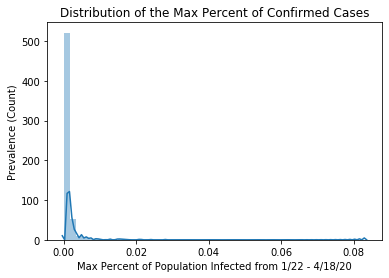

In [9]:
sns.distplot(thresholds["Max_Percent_Confirmed"], norm_hist=False)
plt.ylabel("Prevalence (Count)")
plt.xlabel("Max Percent of Population Infected from 1/22 - 4/18/20")
plt.title("Distribution of the Max Percent of Confirmed Cases")

# Feature Selection

### Create Test/Train Sets

In [16]:
train, test = train_test_split(thresholds, test_size=.20, random_state=42)

### Cross Validation Set-Up

This function takes in training data (we will be passing in training data with different features) and calculates the loss

In [17]:
def cross_validate_mse(model, train, y):
    five_fold = KFold(n_splits=5)
    mse_values = []
    for tr_ind, va_ind in five_fold.split(train):
        model.fit(train.iloc[tr_ind, :], y.iloc[tr_ind])
        mse_values.append(mean_squared_error(y.iloc[va_ind], model.predict(train.iloc[va_ind,:])))
    return np.mean(mse_values)


### Testing Different Features

We define the features we plan to use, and exclude the ones that we cannot use (for example, UID or county name)

In [18]:
all_features = list(thresholds.columns)
print(all_features)
usable_features = ['MedianAge2010', 'RespMortalityRate2014', 'dem_to_rep_ratio', 'SVIPercentile', 'Hospitals Per Capita', 'First Confirmed Case UTC']
usable_features

['UID', 'iso2', 'iso3', 'code3', 'countyFIPS', 'Admin2', 'Province_State', 'Country_Region', 'Combined_Key', 'MedianAge2010', '#Hospitals', 'PopulationEstimate2018', 'RespMortalityRate2014', 'dem_to_rep_ratio', 'SVIPercentile', 'Hospitals Per Capita', 'Max_Confirmed', 'Max_Percent_Confirmed', 'First Confirmed Case UTC']


['MedianAge2010',
 'RespMortalityRate2014',
 'dem_to_rep_ratio',
 'SVIPercentile',
 'Hospitals Per Capita',
 'First Confirmed Case UTC']

We run through different combinations of these features, testing on both `LinearRegression` and `DecisionTreeRegressor` models, and see which ones work best

In [28]:
# Indices of the usable_features
# 0, 1, 2 means we use MedianAge2010, RespMortalityRate2014, and demo_to_rep_ratio
combinations = [
    [0, 1, 2, 3, 4, 5],
    [0, 1, 2, 3, 4],
    [0, 1, 2],
]

y = train['Max_Percent_Confirmed']
best_combination = 0
min_loss = math.inf
best_model_is_linear = True
for i in range(len(combinations)):
    print('TESTING COMBINATION: {}'.format(i))
    combination = combinations[i]
    features = [usable_features[j] for j in combination]
    training_data = train[features]
    linear_error = cross_validate_mse(LinearRegression(), training_data, y)
    tree_error = cross_validate_mse(tree.DecisionTreeRegressor(), training_data, y)
    loss = min(linear_error, tree_error)
    print('LINEAR ERROR: {}'.format(linear_error))
    print('TREE ERROR: {}'.format(tree_error))
    print()
    if loss < min_loss:
        min_loss = loss
        best_combination = i
        best_model_is_linear = linear_error < tree_error

print('SUMMARY')
print('BEST COMBINATION: {} WITH LOSS OF {}'.format(best_combination, min_loss))
    
    

TESTING COMBINATION: 0
LINEAR ERROR: 6.976412746901609e-06
TREE ERROR: 9.9614055108097e-06

TESTING COMBINATION: 1
LINEAR ERROR: 7.2302338241002384e-06
TREE ERROR: 1.1072177568235176e-05

TESTING COMBINATION: 2
LINEAR ERROR: 7.279263431316229e-06
TREE ERROR: 1.0644395747258301e-05

SUMMARY
BEST COMBINATION: 0 WITH LOSS OF 6.976412746901609e-06
